In [2]:
import numpy as np
import matplotlib.pyplot as plt
import iminuit
import math
from statnight.utils.wrappers import ModelWrapper, LossFunctionWrapper, MinimizerWrapper
from statnight.parameters import POI
from statnight.utils.stats import integrate1d
from statnight.hypothesis import Hypothesis
from statnight.hypotest import Discovery
from statnight.calculators import AsymptoticCalculator
from statnight.config import Config

In [3]:
import tensorflow as tf
import zfit
from zfit import ztf

/Users/matthieumarinangeli/anaconda3/envs/tfn/lib/python3.6/site-packages/zfit-0.0.0-py3.6.egg/zfit/util/execution.py:53: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


## Signal + background fit:

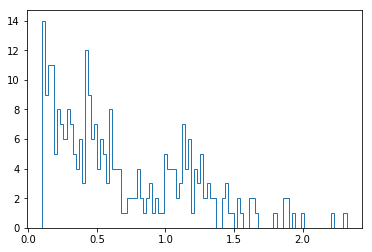

In [4]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 40)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

plt.hist(data, bins=100, histtype='step');

In [5]:
obs = zfit.Space('x', limits=bounds)

In [6]:
mean = zfit.Parameter("mean", 1.2, 0.1, 2., floating=False)
sigma = zfit.Parameter("sigma", 0.1, floating=False)
lambda_ = zfit.Parameter("lambda",-2.0, -5.0, -0.1)
Nsig = zfit.Parameter("Nsig", 20., -10., len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0., len(data)*1.1)

In [7]:
signal = Nsig * zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma)
#signal = zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma)
#signal = signal.create_extended(Nsig)
background =  Nbkg * zfit.pdf.Exponential(obs=obs, lambda_=lambda_)
tot_model = signal + background

In [8]:
zfit.run(mean.assign(1.2))

1.2

In [9]:
# Create the negative log likelihood
from zfit.core.loss import ExtendedUnbinnedNLL, UnbinnedNLL
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)

nll = ExtendedUnbinnedNLL(model=[tot_model], data=[data_], fit_range=[obs]) 

In [10]:
# Load and instantiate a tensorflow minimizer
from zfit.minimizers.minimizer_minuit import MinuitMinimizer
minimizer = MinuitMinimizer()

In [11]:
# Create the minimization graph to minimize mu and sigma and run it (minimize does it directly)
minimum = minimizer.minimize(loss=nll)

FCN = -1219.4519089430983 
 TOTAL NCALL = 73 
 NCALLS = 73 
 
 
 EDM = 6.550073002697365e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,Nbkg,251.016,16.798,,,0,314.6,No
1,lambda,-1.94411,0.142076,,,-5,-0.1,No
2,Nsig,34.9784,8.22975,,,-10,286,No


In [12]:
zfit.run(tot_model.integrate(bounds))

285.99448723022874

In [13]:
zfit.run(signal.integrate(bounds))

34.97841538916651

In [14]:
zfit.run(background.integrate(bounds))

251.01607184106226

In [15]:
def plotfitresult(pdf, bounds, nbins, data):
    x = np.linspace(*bounds, num=1000)
    pdf = zfit.run(tot_model.pdf(x, norm_range=bounds))
    _ = plt.plot(x, ((bounds[1] - bounds[0])/nbins)*(pdf), "-r")

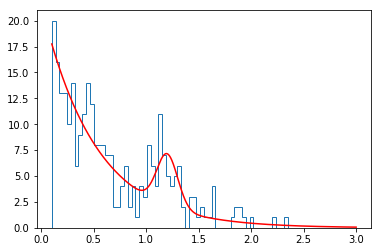

In [16]:
nbins = 80
plt.hist(data, bins=nbins, histtype='step', range=bounds);
plotfitresult(tot_model, bounds, nbins, data)

In [17]:
def profileLikelihood(var, value):
    zfit.run(var.assign(value))
    var.floating = False
    mini = minimizer
    mini.verbosity = 0
    minimum = mini.minimize(loss=nll)
    return minimum.fmin
    

In [18]:
Nsig

<tf.Variable 'Nsig' shape=() dtype=float64>

In [19]:
profileLikelihood(Nsig, 35.5)

-1219.449789244437

In [20]:
nsig = np.linspace(15,50,30)
nll_ = np.empty(nsig.shape)

In [21]:
for i, n in np.ndenumerate(nsig):
    nll_[i] = profileLikelihood(Nsig, n)
nll_ -= np.min(nll_)

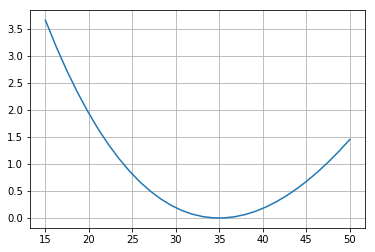

In [22]:
plt.plot(nsig, nll_)
plt.grid(True)

## Discovery significance.

In [23]:
def lossbuilder(model, data, weights=None):
    loss = LossFunctionWrapper(probfit.UnbinnedLH(model, data, extended=True, extended_bound=bounds, weights=weights))
    return loss
    
config = Config(tot_model, data, lossbuilder, MinimizerWrapper)
config.bestfit = minimizer.values

TypeError: __init__() missing 1 required positional argument: 'pll'

In [ ]:
calc = AsymptoticCalculator(config)

In [ ]:
poinull = POI("Nsig", value=0)
discovery_test = Discovery(poinull, calc)

In [ ]:
discovery_test.result();